In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow.keras as tf
from tensorflow.keras.metrics import Precision, Recall

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
### merges ###
tables = {"ser": "SERVICES.csv", "pat": "PATIENTS.csv", "stay": "ICUSTAYS.csv", "adm": "ADMISSIONS.csv"}

#admissions
df = pd.read_csv("mimic/"+tables["adm"])
df = df[["SUBJECT_ID", "HADM_ID", "ADMITTIME", "ADMISSION_TYPE", "INSURANCE", "MARITAL_STATUS", "ETHNICITY", "DIAGNOSIS", "HOSPITAL_EXPIRE_FLAG"]]

#patients
df1 = pd.read_csv("mimic/"+tables["pat"])
df1 = df1[["SUBJECT_ID", "GENDER", "DOB"]]

df = df.merge(df1, how="left")
df = df.dropna()

df["ADMITTIME"] = pd.to_datetime(df["ADMITTIME"]).map(lambda x: x.year)
df["DOB"] = pd.to_datetime(df["DOB"]).map(lambda x: x.year)
df["AGE"] = df["ADMITTIME"] - df["DOB"]
df = df[df["AGE"] < 130]
df = df.drop(['DOB', 'ADMITTIME'], axis=1)

df = df[df["DIAGNOSIS"].str.contains("(CONGESTIVE HEART FAILURE)|(ATRIAL FIBRILLATION)")]


#services
df1 = pd.read_csv("mimic/"+tables["ser"])
df1 = df1[["SUBJECT_ID", "HADM_ID", "PREV_SERVICE", "CURR_SERVICE"]]

df = df.merge(df1, how="left")

df["PREV_SERVICE"] = df["PREV_SERVICE"].apply(lambda x: x if x == "CMED" or x == "CSURG" else np.NaN)
df["CURR_SERVICE"] = df["CURR_SERVICE"].apply(lambda x: x if x == "CMED" or x == "CSURG" else np.NaN)

df = df.drop(["SUBJECT_ID", "HADM_ID"], axis=1)
df




C:\Users\josue\Anaconda3\envs\TensorFlow01\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,ADMISSION_TYPE,INSURANCE,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,GENDER,AGE,PREV_SERVICE,CURR_SERVICE
0,EMERGENCY,Medicare,MARRIED,WHITE,CONGESTIVE HEART FAILURE,0,M,69,NaN,CMED
1,EMERGENCY,Private,MARRIED,UNKNOWN/NOT SPECIFIED,CONGESTIVE HEART FAILURE,0,M,61,NaN,CMED
2,EMERGENCY,Medicare,SEPARATED,HISPANIC OR LATINO,HYPERKALEMIA;CONGESTIVE HEART FAILURE,0,M,69,NaN,NaN
3,EMERGENCY,Medicare,SEPARATED,HISPANIC OR LATINO,HYPERKALEMIA;CONGESTIVE HEART FAILURE,0,M,69,NaN,CMED
4,URGENT,Medicare,MARRIED,UNKNOWN/NOT SPECIFIED,CONGESTIVE HEART FAILURE\CATH,0,M,85,NaN,CMED
...,...,...,...,...,...,...,...,...,...,...
2215,EMERGENCY,Medicare,SEPARATED,BLACK/AFRICAN AMERICAN,CONGESTIVE HEART FAILURE,0,F,45,CMED,CSURG
2216,ELECTIVE,Medicare,MARRIED,WHITE,DRUG REFRACTORY ATRIAL FIBRILLATION\PULMONARY ...,0,M,72,NaN,CMED
2217,ELECTIVE,Medicare,MARRIED,WHITE,CONGESTIVE HEART FAILURE\Transcatheter Aortic ...,0,M,81,NaN,CSURG
2218,ELECTIVE,Medicare,MARRIED,WHITE,CONGESTIVE HEART FAILURE\Transcatheter Aortic ...,0,M,81,CSURG,CMED


In [6]:

norm_df = df["HOSPITAL_EXPIRE_FLAG"].to_frame()

def creNormNum(st):
    norm_df[st] = (df[st] - df[st].mean()) / (df[st].max() - df[st].min())

def creCat(st):
    vals = df[st].unique()
    
    for val in vals:
        if(val == val):
            norm_df[st + "--" + str(val)] = df[st].apply(lambda x: 1 if x == val else 0)


norm_df["GENDER"] = df["GENDER"].apply(lambda x: 1 if x == 'M' else -1)

creCat("ADMISSION_TYPE")
creCat("INSURANCE")
creCat("MARITAL_STATUS")
creNormNum("AGE")
creCat("ETHNICITY")

norm_df["DIAGNOSIS"] = df["DIAGNOSIS"].apply(lambda x: 1 if "CONGESTIVE HEART FAILURE" in x else -1)

creCat("PREV_SERVICE")
creCat("CURR_SERVICE")

norm_df["DEAD"] = df["HOSPITAL_EXPIRE_FLAG"]
norm_df = norm_df.drop(["HOSPITAL_EXPIRE_FLAG"], axis=1)


norm_df.to_csv("mimic_norm.csv", index=False)

In [4]:


###################### Start Here ######################################



norm_df = pd.read_csv("mimic_norm.csv")
(trainX, testX, trainY, testY) = train_test_split(norm_df.iloc[:, :-1], norm_df.iloc[:, -1], test_size=0.2)
trainX

,GENDER,ADMISSION_TYPE--EMERGENCY,ADMISSION_TYPE--URGENT,ADMISSION_TYPE--ELECTIVE,INSURANCE--Medicare,INSURANCE--Private,INSURANCE--Medicaid,INSURANCE--Government,INSURANCE--Self Pay,MARITAL_STATUS--MARRIED,...,ETHNICITY--ASIAN - CAMBODIAN,ETHNICITY--ASIAN - FILIPINO,ETHNICITY--ASIAN - ASIAN INDIAN,ETHNICITY--WHITE - EASTERN EUROPEAN,ETHNICITY--HISPANIC/LATINO - CENTRAL AMERICAN (OTHER),DIAGNOSIS,PREV_SERVICE--CMED,PREV_SERVICE--CSURG,CURR_SERVICE--CMED,CURR_SERVICE--CSURG
1514,-1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,-1,0,0,1,0
318,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
457,1,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,-1,0,0,1,0
789,1,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
43,1,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,-1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
735,1,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
628,-1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1299,-1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,-1,1,0,0,0


In [40]:
df["MARITAL_STATUS"].unique()

array(['MARRIED', 'SEPARATED', 'WIDOWED', 'SINGLE', 'DIVORCED',
       'UNKNOWN (DEFAULT)', 'LIFE PARTNER'], dtype=object)

In [6]:
data_input = tf.layers.Input(shape=(trainX.shape[1],))

hidden = tf.layers.Dense(30, activation="tanh")(data_input)
hidden = tf.layers.Dense(15, activation="tanh")(hidden)
hidden = tf.layers.Dense(5, activation="tanh")(hidden)
hidden = tf.layers.Dropout(0.2)(hidden)
data_output = tf.layers.Dense(1, activation="sigmoid")(hidden)

model = tf.Model(inputs=data_input, outputs=data_output)

# compile model
model.compile(optimizer="adam", loss='mean_squared_error', metrics=["accuracy", tf.metrics.Precision(), tf.metrics.Recall()])

history = model.fit(trainX, trainY, validation_split=0.33, epochs=200)




Train on 1189 samples, validate on 587 samples
Epoch 1/200
1189/1189 [==============================] - 1s 1ms/sample - loss: 0.1640 - accuracy: 0.8385 - precision: 0.0893 - recall: 0.0342 - val_loss: 0.1158 - val_accuracy: 0.8825 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
1189/1189 [==============================] - 0s 161us/sample - loss: 0.1186 - accuracy: 0.8772 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1059 - val_accuracy: 0.8825 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
1189/1189 [==============================] - 0s 204us/sample - loss: 0.1132 - accuracy: 0.8772 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1040 - val_accuracy: 0.8825 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
1189/1189 [==============================] - 0s 173us/sample - loss: 0.1122 - accuracy: 0.8772 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1034 - val_accuracy: 0.8825 - val_precision: 0.0000e+00 

1189/1189 [==============================] - 0s 174us/sample - loss: 0.0989 - accuracy: 0.8831 - precision: 1.0000 - recall: 0.0479 - val_loss: 0.1025 - val_accuracy: 0.8825 - val_precision: 0.5000 - val_recall: 0.0290
Epoch 70/200
1189/1189 [==============================] - 0s 164us/sample - loss: 0.0979 - accuracy: 0.8823 - precision: 0.7500 - recall: 0.0616 - val_loss: 0.1018 - val_accuracy: 0.8825 - val_precision: 0.5000 - val_recall: 0.0290
Epoch 71/200
1189/1189 [==============================] - 0s 149us/sample - loss: 0.0995 - accuracy: 0.8831 - precision: 0.8889 - recall: 0.0548 - val_loss: 0.1029 - val_accuracy: 0.8825 - val_precision: 0.5000 - val_recall: 0.0290
Epoch 72/200
1189/1189 [==============================] - 0s 156us/sample - loss: 0.0988 - accuracy: 0.8823 - precision: 0.8000 - recall: 0.0548 - val_loss: 0.1026 - val_accuracy: 0.8825 - val_precision: 0.5000 - val_recall: 0.0290
Epoch 73/200
1189/1189 [==============================] - 0s 147us/sample - loss: 0.0

1189/1189 [==============================] - 0s 207us/sample - loss: 0.0933 - accuracy: 0.8873 - precision: 1.0000 - recall: 0.0822 - val_loss: 0.1021 - val_accuracy: 0.8790 - val_precision: 0.3333 - val_recall: 0.0290
Epoch 140/200
1189/1189 [==============================] - 0s 158us/sample - loss: 0.0956 - accuracy: 0.8865 - precision: 0.7391 - recall: 0.1164 - val_loss: 0.1004 - val_accuracy: 0.8825 - val_precision: 0.5000 - val_recall: 0.0290
Epoch 141/200
1189/1189 [==============================] - 0s 159us/sample - loss: 0.0920 - accuracy: 0.8856 - precision: 0.8125 - recall: 0.0890 - val_loss: 0.1013 - val_accuracy: 0.8807 - val_precision: 0.4000 - val_recall: 0.0290
Epoch 142/200
1189/1189 [==============================] - 0s 244us/sample - loss: 0.0932 - accuracy: 0.8856 - precision: 0.8571 - recall: 0.0822 - val_loss: 0.1008 - val_accuracy: 0.8807 - val_precision: 0.4000 - val_recall: 0.0290
Epoch 143/200
1189/1189 [==============================] - 0s 255us/sample - loss:

Epoch 174/200
1189/1189 [==============================] - 0s 197us/sample - loss: 0.0907 - accuracy: 0.8823 - precision: 0.7143 - recall: 0.0685 - val_loss: 0.1004 - val_accuracy: 0.8825 - val_precision: 0.5000 - val_recall: 0.0290
Epoch 175/200
1189/1189 [==============================] - 0s 252us/sample - loss: 0.0905 - accuracy: 0.8831 - precision: 0.7059 - recall: 0.0822 - val_loss: 0.1015 - val_accuracy: 0.8825 - val_precision: 0.5000 - val_recall: 0.0435
Epoch 176/200
1189/1189 [==============================] - 0s 164us/sample - loss: 0.0916 - accuracy: 0.8823 - precision: 0.7143 - recall: 0.0685 - val_loss: 0.1005 - val_accuracy: 0.8825 - val_precision: 0.5000 - val_recall: 0.0290
Epoch 177/200
1189/1189 [==============================] - 0s 156us/sample - loss: 0.0910 - accuracy: 0.8881 - precision: 0.8421 - recall: 0.1096 - val_loss: 0.1013 - val_accuracy: 0.8807 - val_precision: 0.4000 - val_recall: 0.0290
Epoch 178/200
1189/1189 [==============================] - 0s 168us/

444/444 [==============================] - 0s 87us/sample - loss: 0.0996 - accuracy: 0.8829 - precision: 0.3750 - recall: 0.0600
---------------------------------------------------------------------------

accuracy: 88.29%

precision: 37.50%

Data Distribution Ratio (7.26046511627907): 
	Survived: 1561
	Not survived: 215
---------------------------------------------------------------------------

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
dense (Dense)                (None, 30)                1500      
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 80

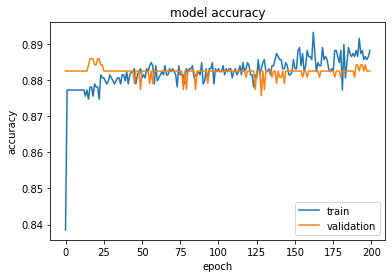

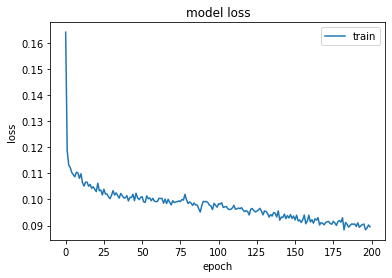

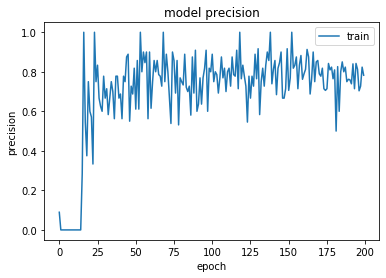

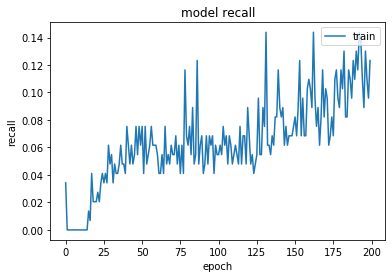

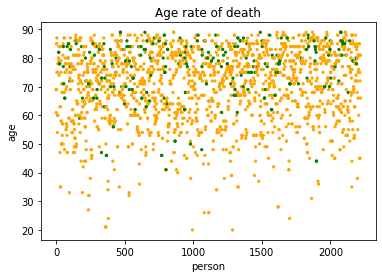

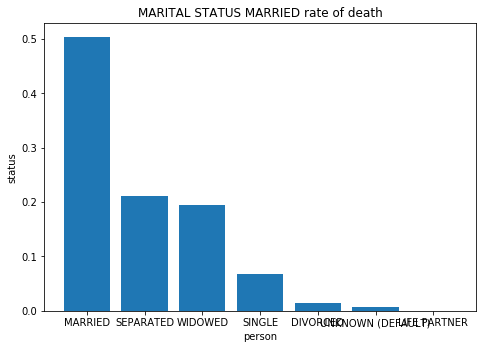

In [27]:
scores = model.evaluate(testX, testY)

print("---------------------------------------------------------------------------")
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("\n%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))

print("\nData Distribution Ratio ("+str(list(trainY).count(0) / list(trainY).count(1))+"): ")
print("\tSurvived: " +str(list(trainY).count(0)))
print("\tNot survived: " + str(list(trainY).count(1)))
print("---------------------------------------------------------------------------")

print()
model.summary()

print()
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['precision'])
#plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['recall'])
#plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


cols = ['orange' if i == 0 else 'green' for i in norm_df["DEAD"]]

plt.scatter(range(len(df["AGE"])), df["AGE"], s=5, c=cols);
plt.title('Age rate of death')
plt.ylabel('age')
plt.xlabel('person')
#plt.legend(['survived', 'not survived'], loc='lower right')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = list(df["MARITAL_STATUS"].unique())
students = list(df["MARITAL_STATUS"].value_counts(normalize=True))
ax.bar(langs,students)

plt.title('MARITAL STATUS MARRIED rate of death')
plt.ylabel('status')
plt.xlabel('person')
#plt.legend(['survived', 'not survived'], loc='lower right')
plt.show()



In [21]:
predic = model.predict(trainX)
predic

array([[0.03157437],
       [0.02044946],
       [0.03221908],
       ...,
       [0.02213126],
       [0.09418929],
       [0.01309144]], dtype=float32)

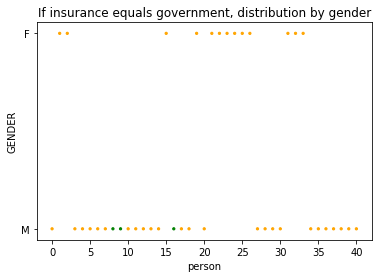

In [16]:

Attr = "INSURANCE"
Cond = "Government"
Data = "GENDER"


toplot = df[df[Attr] == Cond][Data]
cols = ['orange' if i == 0 else 'green' for i in norm_df[df[Attr] == Cond]["DEAD"]]

plt.scatter(range(len(toplot)), toplot, s=5, c=cols);
plt.title("If " + Attr.lower() + " equals " + Cond.lower() + ", distribution by " + Data.lower())
plt.ylabel(Data)
plt.xlabel('person')
#plt.legend(['survived', 'not survived'], loc='lower right')
plt.show()



0.13136729222520108
0.10672853828306264


C:\Users\josue\Anaconda3\envs\TensorFlow01\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\josue\Anaconda3\envs\TensorFlow01\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
